In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
def get_image(path, img_transform, size = (300,300)):
    image = Image.open(path)
    image = image.resize(size, Image.LANCZOS)
    image = img_transform(image).unsqueeze(0)
    return image.to(device)

def get_gram(m):
    _, c, h, w = m.size()
    m = m.view(c, h * w)
    m = torch.mm(m, m.t()) 
    return m

def denormalize_img(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

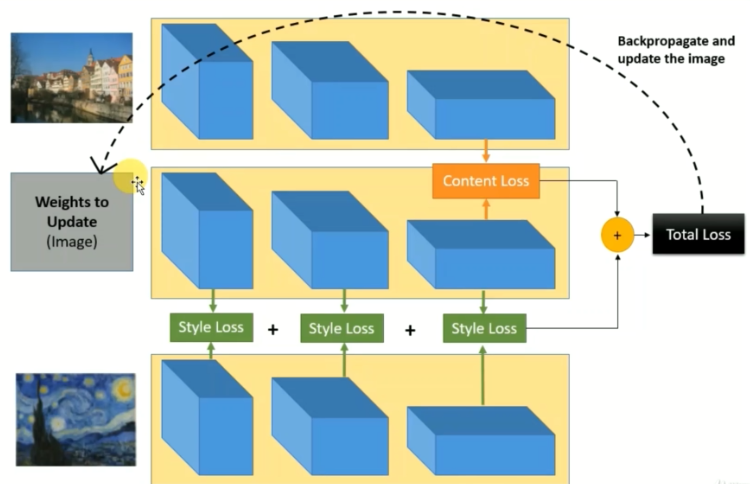

In [3]:
# Exploring
models.vgg16(pretrained=True).features

/home/derek/Documents/venvs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/derek/Documents/venvs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [4]:
# Exploring
models.vgg16(pretrained=True).features._modules

OrderedDict([('0',
              Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('1', ReLU(inplace=True)),
             ('2',
              Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('3', ReLU(inplace=True)),
             ('4',
              MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
             ('5',
              Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('6', ReLU(inplace=True)),
             ('7',
              Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('8', ReLU(inplace=True)),
             ('9',
              MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
             ('10',
              Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('11', ReLU(inplace=True)),
             ('12',
              Conv2d(256, 256, kernel_size=(3, 3)

In [5]:
# Exploring
models.vgg16(pretrained=True).features._modules.items()

odict_items([('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('1', ReLU(inplace=True)), ('2', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('3', ReLU(inplace=True)), ('4', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('5', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('6', ReLU(inplace=True)), ('7', Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('8', ReLU(inplace=True)), ('9', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('10', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('11', ReLU(inplace=True)), ('12', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('13', ReLU(inplace=True)), ('14', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('15', ReLU(inplace=True)), ('16', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('17', Conv2d(25

In [6]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.selected_layers = [3, 8, 15, 22] # For style loss! vgg16 has relu in these layers
        self.vgg = models.vgg16(pretrained=True).features
        
    def forward(self, x):
        layer_features = []
        for layer_number, layer in self.vgg._modules.items():
            x = layer(x)
            if int(layer_number) in self.selected_layers:
                layer_features.append(x)
        return layer_features

In [7]:
img_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])
content_img = get_image('content.jpg', img_transform)
style_img = get_image('style.jpg', img_transform)
# generated_img = nn.Parameter(torch.FloatTensor(content_img.size())) This is a long and slow method
# Instead just initializing gen_img to content_img after which we only need to focus on style!
generated_img = content_img.clone()

/tmp/ipykernel_43388/2100676859.py:3: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize(size, Image.LANCZOS)


In [8]:
print(generated_img)
print(generated_img.requires_grad)

tensor([[[[ 1.6153,  1.6153,  1.6153,  ..., -0.6452, -0.3198, -0.6965],
          [ 1.6153,  1.6153,  1.6153,  ..., -0.9192, -0.6794, -1.2959],
          [ 1.6153,  1.6153,  1.5982,  ..., -1.2788, -1.6213, -1.1418],
          ...,
          [-1.9124, -1.8268, -1.8782,  ..., -1.6727, -1.4672, -1.5699],
          [-1.9467, -1.9467, -1.9467,  ..., -1.3644, -1.6898, -1.3987],
          [-1.9980, -2.0323, -2.0323,  ..., -1.4843, -1.6898, -1.3644]],

         [[ 2.0259,  2.0259,  2.0259,  ..., -0.3025,  0.1001, -0.3025],
          [ 2.0084,  2.0084,  2.0259,  ..., -0.5301, -0.3025, -1.0203],
          [ 2.0084,  2.0084,  2.0084,  ..., -0.9503, -1.4055, -0.8102],
          ...,
          [-1.7556, -1.6331, -1.7031,  ..., -1.6856, -1.4930, -1.5805],
          [-1.7906, -1.7906, -1.7906,  ..., -1.4755, -1.7031, -1.4930],
          [-1.8431, -1.8782, -1.8782,  ..., -1.5280, -1.7206, -1.4580]],

         [[ 2.0474,  2.0474,  2.0125,  ..., -0.3927,  0.0431, -0.2881],
          [ 2.0474,  2.0300,  

Therefore the generated_img is not fit for learning.

In [9]:
generated_img.requires_grad = True

In [10]:
optimizer = torch.optim.Adam([generated_img], lr=0.003, betas=[0.5, 0.999])
encoder = FeatureExtractor().to(device)

# Freezing Parameters
for p in encoder.parameters():
    p.requires_grad = False
# Alternative encoder.eval()

In [11]:
content_weight = 1 # From Paper
style_weight = 100

for epoch in range(500):
    
    content_features = encoder(content_img)
    style_features = encoder(style_img)
    generated_features = encoder(generated_img)
    
    content_loss = torch.mean((content_features[-1] - generated_features[-1])**2)  

    style_loss = 0
    for gf, sf in zip(generated_features, style_features):
        _, c, h, w = gf.size() # same as sf.size()
        gram_gf = get_gram(gf)
        gram_sf = get_gram(sf)
        style_loss += torch.mean((gram_gf - gram_sf)**2)  / (c * h * w) # to normalize mean

    loss = content_weight * content_loss + style_weight * style_loss 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print ('Epoch [{}]\tContent Loss: {:.4f}\tStyle Loss: {:.4f}'.format(epoch, content_loss.item(), style_loss.item()))


Epoch [0]	Content Loss: 0.0000	Style Loss: 220.0416
Epoch [10]	Content Loss: 0.8929	Style Loss: 139.6100
Epoch [20]	Content Loss: 1.1260	Style Loss: 101.4629
Epoch [30]	Content Loss: 1.2541	Style Loss: 78.1832
Epoch [40]	Content Loss: 1.3462	Style Loss: 62.9427
Epoch [50]	Content Loss: 1.4194	Style Loss: 52.5100
Epoch [60]	Content Loss: 1.4819	Style Loss: 45.1399
Epoch [70]	Content Loss: 1.5356	Style Loss: 39.7725
Epoch [80]	Content Loss: 1.5836	Style Loss: 35.7330
Epoch [90]	Content Loss: 1.6252	Style Loss: 32.5687
Epoch [100]	Content Loss: 1.6619	Style Loss: 29.9960
Epoch [110]	Content Loss: 1.6943	Style Loss: 27.8387
Epoch [120]	Content Loss: 1.7223	Style Loss: 25.9817
Epoch [130]	Content Loss: 1.7488	Style Loss: 24.3516
Epoch [140]	Content Loss: 1.7707	Style Loss: 22.9053
Epoch [150]	Content Loss: 1.7887	Style Loss: 21.6106
Epoch [160]	Content Loss: 1.8045	Style Loss: 20.4402
Epoch [170]	Content Loss: 1.8185	Style Loss: 19.3803
Epoch [180]	Content Loss: 1.8310	Style Loss: 18.4160
E

In [19]:
inp = generated_img.detach().cpu()
inp.shape

torch.Size([1, 3, 300, 300])

In [21]:
inp = inp.squeeze()
inp.shape

torch.Size([3, 300, 300])

In [22]:
inp = denormalize_img(inp)

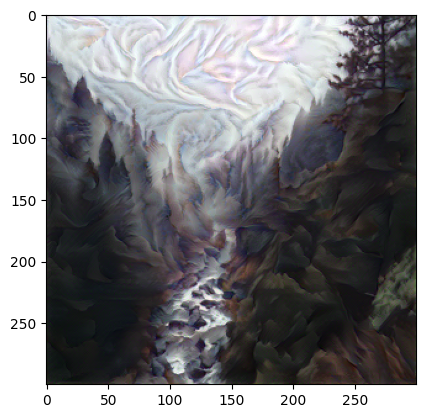

In [23]:
plt.imshow(inp)